In [1]:
from sklearn.manifold import TSNE
import tensorflow as tf
import numpy as np
import pywt
import matplotlib.pyplot as plt
from vae import VariationalAutoencoder
from matplotlib.gridspec import GridSpec


def _parse_input(serialised_input):
    """ Parse serialised input into labelled dataset with NSynth features """
    parsed_output = tf.parse_single_example(serialised_input, nsynth_feature)
    return parsed_output


def filter_func(features):
    """ Filter input data"""
    result = tf.reshape(tf.equal(features['qualities'][2], 1), [])
    return result


def pre_process(batch, preproc=None):
    """ Handles pre-processing of input data, using DWT or DFT
    Normalises data to fit into [0, 1] range
    """
    if preproc == 'DWT':
        wt = pywt.Wavelet(wavelet)
        batch = pywt.wavedec(batch, wt, axis=1, level=6)
        batch = np.hstack(batch)[:, :time_steps]
        batch = np.square(batch)
        batch = np.divide(batch, np.amax(batch, axis=1)[:, None]+1e-10)
    elif preproc == 'DFT':
        batch = np.absolute(np.fft.fft(batch, axis=1))
        batch = np.divide(batch, np.amax(batch, axis=1)[:, None]+1e-10)
    elif preproc is None:
        batch = np.square(batch)
    else:
        print('invalid preproc')
        batch = np.square(batch)
    return batch


def test_plot(vae, valid, preproc=None):
    """ Plot a sample from valid dataset and its reconstruction
    for manual validation
    """
    valid_in = valid.eval()
    valid_in = pre_process(valid_in, preproc)
    valid_recon = vae.reconstruct(valid_in)
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True)
    ax1.plot(valid_in[0])
    ax2.plot(valid_recon[0])
    plt.show()
    return(valid_in)


time_steps = 16000 * 4
wavelet = 'db1'
nsynth_feature = {
    'note': tf.FixedLenFeature([], tf.int64),
    'note_str': tf.FixedLenFeature([], tf.string),
    'instrument': tf.FixedLenFeature([], tf.int64),
    'instrument_str': tf.FixedLenFeature([], tf.string),
    'pitch': tf.FixedLenFeature([], tf.int64),
    'velocity': tf.FixedLenFeature([], tf.int64),
    'sample_rate': tf.FixedLenFeature([], tf.int64),
    'audio': tf.FixedLenFeature([time_steps], tf.float32),
    'qualities': tf.FixedLenFeature([10], tf.int64),
    'qualities_str': tf.VarLenFeature(tf.string),
    'instrument_family': tf.FixedLenFeature([], tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], tf.string),
    'instrument_source': tf.FixedLenFeature([], tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], tf.string),
}

sub_samp = 2
div = 8
time_steps = time_steps // sub_samp // div
batch_size = 50
n_samples = 289205

# Define number of nodes in each layer
vae_architecture = dict(
    n_hidden_recog_1=2000,
    n_hidden_recog_2=1000,
    n_hidden_gener_1=1000,
    n_hidden_gener_2=2000,
    n_input=time_steps,
    n_output=time_steps,
    n_z=64
)

vae = VariationalAutoencoder(vae_architecture, batch_size=batch_size, restore='DWT')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tmp/modelDWT.ckpt


In [2]:
nsynth_valid_2 = tf.data.TFRecordDataset("nsynth-valid.tfrecord")
nsynth_valid_1 = nsynth_valid_2.map(_parse_input)
nsynth_valid = nsynth_valid_1.filter(filter_func).shuffle(buffer_size=1000).repeat().batch(50)

iterator = nsynth_valid.make_one_shot_iterator().get_next()['audio']
valid = vae.sess.run(iterator)[:, :16000*4//div:sub_samp]

In [3]:
preproc = 'DWT'
valid_procc = pre_process(valid, preproc)
valid_recon = vae.reconstruct(valid_procc)
valid_recon = np.divide(valid_recon, np.amax(valid_recon, axis=1)[:, None]+1e-10)



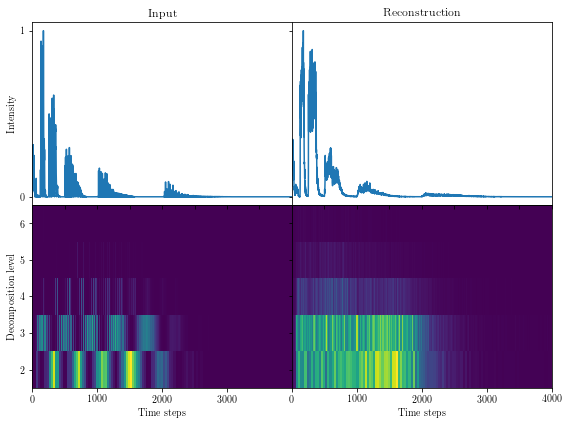

In [13]:
it=10
procc = np.square(pywt.wavedec(valid[it], pywt.Wavelet('db1'), level=6))
procc /= np.amax(np.hstack(procc))
maxlen = len(procc[-1])

procc_scalo = np.zeros((len(procc)-2, maxlen))
recon_scalo = np.zeros((len(procc)-2, maxlen))
counter=len(procc[0])+len(procc[1])
for i in range(len(procc)-2):
    each = procc[i+2]
    each_len = len(each)
    for j in range(maxlen):
        if j//(maxlen//each_len) < each_len and (j)//(maxlen//each_len)+counter<4000:
            procc_scalo[i,j] = each[j//(maxlen//each_len)]
            recon_scalo[i,j] = valid_recon[it][(j)//(maxlen//each_len)+counter]
    counter += each_len
counter=0
recon = []
for i,v in enumerate(procc):
    recon.append(np.zeros(len(v)))
    for j,_ in enumerate(v):
        if j+counter<len(valid_recon[it]):
            recon[i][j] = np.sqrt(valid_recon[it,j+counter])
    counter+=len(v)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig=plt.figure(figsize=(8, 6))

gs=GridSpec(2,2) 

ax1=fig.add_subplot(gs[1,0]) 
ax2=fig.add_subplot(gs[1,1]) 
ax3=fig.add_subplot(gs[0,0])
ax4=fig.add_subplot(gs[0,1])

im = ax1.imshow(procc_scalo)
ax1.set_aspect(aspect="auto")
ax1.set_ylim([-0.5, 4.5])
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_yticklabels([2, 3, 4, 5, 6])
ax1.set_ylabel('Decomposition level')
ax1.set_xticks([0, 500, 1000, 1500])
ax1.set_xticklabels([0, 1000, 2000, 3000])
ax1.set_xlabel('Time steps')

im = ax2.imshow(recon_scalo)
ax2.set_aspect(aspect="auto")
ax2.set_ylim([-0.5, 4.5])
ax2.set_yticklabels([])
ax2.set_xticks([0, 500, 1000, 1500, 2000])
ax2.set_xticklabels([0, 1000, 2000, 3000, 4000])
ax2.set_xlabel('Time steps')


ax3.plot(valid_procc[it])
ax3.set_yticks([0, 1])
ax3.set_xlim([0, 4000])
ax3.set_ylabel('Intensity')
ax3.set_xticklabels([])

ax4.plot(valid_recon[it])
ax4.set_yticks([0, 1])
ax4.set_xlim([0, 4000])
ax4.set_yticklabels([])
ax4.set_xticklabels([])

plt.setp(ax3, title='Input')
plt.setp(ax4, title='Reconstruction')


gs.update(hspace=0, wspace=0)
plt.tight_layout()
fig.savefig('reconDWT_scalo.pdf')

In [5]:
(maxlen//each_len)

1